# Pneunonia X-Ray Analysis

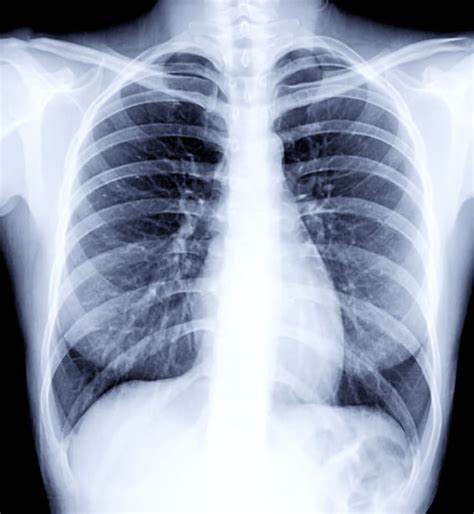

## Overview

The following analysis takes a deeper dive into the research and understanding behind pneumonia. This sickness being an inflammatory condition of the lungs that fills the air sacks with pus and other liquids due to an infection caused by fungi, bacteria, or a virus. Pneumonia can lead to complications like respiratory failure, sepsis, and lung abscesses, especially in high-risk groups such as children, the elderly, and people with lung complications. With that in mind, early detection of pneumonia is crucial according to medical experts. This analysis does just that by taking a deeper look into various x-rays of children between ages of one and five, taken by Guangzhou Women and Children’s Medical Center and determining if the given x-ray image match to that of a person with pneumonia of not. 

## Business Problem

With all this into consideration, our stakeholders, Guangzhou Women and Children’s Medical Center, are requesting for a model to be made that can be used to appropriately distinguish the difference between x-rays classified as "NORMAL" and "PNEUMONIA" in order to continue their efforts in combatting this sickness.

## Data Understanding

The data provided by the stakeholders, consists of 5,863 x-rays. All divided into two classes, patients with pneumonia and normal patients. This data is already slpit into three different groups/folders. The first group being for the training sample; 5,216 images. The second being for testing, with 624 images. And the last being for validation, consisting of only 16 x-ray images.

In [1]:
#importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from keras import layers, models, regularizers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report

Start off by loading the data which is separated into three different folders. A training folder, a testing folder, and a validation folder a presented with various imagines representing different x-ray scans.

In [2]:
# Set the paths to train, test, and validation folders
train_folder = 'C:\\Users\\bryan\\Documents\\Flatiron\\phase_4\\phase_4_project\\chest_xray\\train'
test_folder = 'C:\\Users\\bryan\\Documents\\Flatiron\\phase_4\\phase_4_project\\chest_xray\\test'
val_folder = 'C:\\Users\\bryan\\Documents\\Flatiron\\phase_4\\phase_4_project\\chest_xray\\val'

The dataset is divided into two classes, those being pneumonia and normal, thus being bianary. Also, the train data has 5216 images, the test has 624, and the validation has 16.

Load the images from the specified directories. The pixel values are rescaled and the classmode parameter is set to 'binary' since this is a binary classification.

In [3]:
# Downsampling the images to 128X128 pixels
downsampled_size = (128, 128)

# Rescale pixel values between 0 and 1
datagen = ImageDataGenerator(rescale=1./255)  

# Load train data
train_generator = datagen.flow_from_directory(
    train_folder,
    target_size=downsampled_size,
    batch_size=5216,
    class_mode='binary',
    shuffle=True
)

# Load test data
test_generator = datagen.flow_from_directory(
    test_folder,
    target_size=downsampled_size,
    batch_size=624,
    class_mode='binary',
    shuffle=False
)

# Load validation data
val_generator = datagen.flow_from_directory(
    val_folder,
    target_size=downsampled_size,
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Explore Data

In [5]:
# Retrieve the dictionary of class indices from the train_generator
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())
# Print the list of class labels
print('Class labels: {}'.format(class_names))

Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


Will display samples of the images from the dataset with the corresponding label that is set as the title for each subplot.

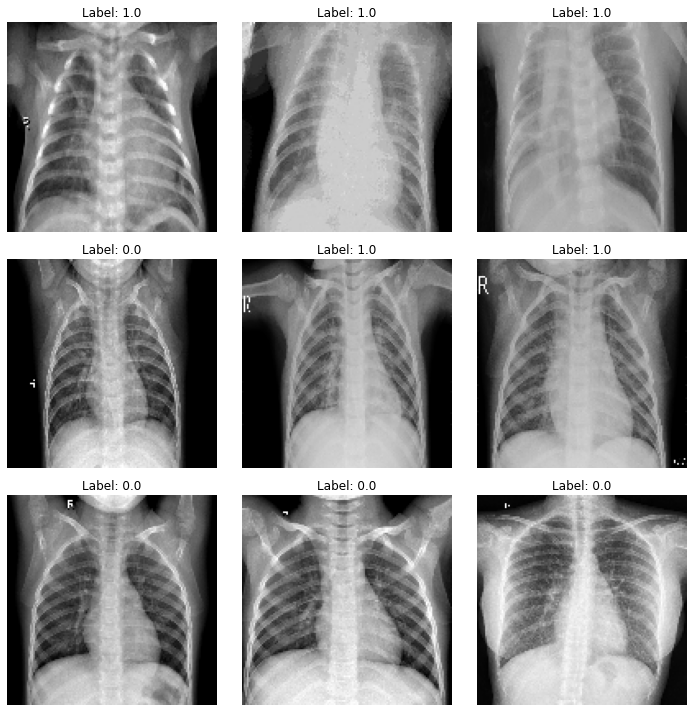

In [6]:
# Get a batch of images from the train generator
batch = next(train_generator)

# Extract the images and labels from the batch
images, labels = batch

# Display the first few images with their corresponding labels
num_images = 9

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(num_images):
    axes[i//3, i%3].imshow(images[i], cmap='RdBu')
    axes[i//3, i%3].set_title('Label: {}'.format(labels[i]))
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()

As previously noted, a label of 0.0 means that it falls under the 'normal' class. Where as a label of 1.0 falls under the 'pneumonia' class. As seen above, it is hard to distinguish at first glance between the normal patients and the sick ones due to high similarity.

Proceed to create a functioin to aid in vizualizing the distributions between 'normal' and patients with 'pneumonia'

In [7]:
def plot_class_counts(labels, title):
    # Get the counts for each class
    class_labels, counts = np.unique(labels, return_counts=True)
    # Calculate the percentage of value counts
    total_count = np.sum(counts)
    percentages = counts / total_count * 100
    # Plot the results
    plt.figure(figsize=(12,10))
    plt.title(f'{title}', fontsize='20')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    # Replace "1" with "Normal" in class_labels list
    class_labels = ['Pneumonia', 'Normal']
    # Add value counts as text on top of each bar
    for i in range(len(class_labels)):
        plt.text(i, counts[i], f"{counts[i]}\n{percentages[i]:.2f}%", ha='left', va='top')
    sns.barplot(x=class_labels, y=counts)
    plt.show()

#### Training data visualization

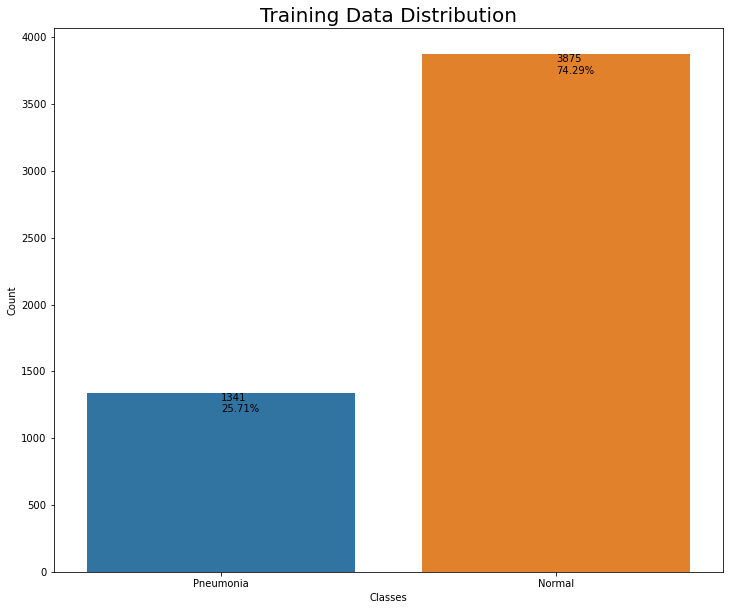

In [8]:
labels = train_generator.classes
plot_class_counts(labels, 'Training Data Distribution')

As shown above, one can note that approximately 25% of the data represents patients with pneumonia while the other 75% is normal.

#### Test data visualization

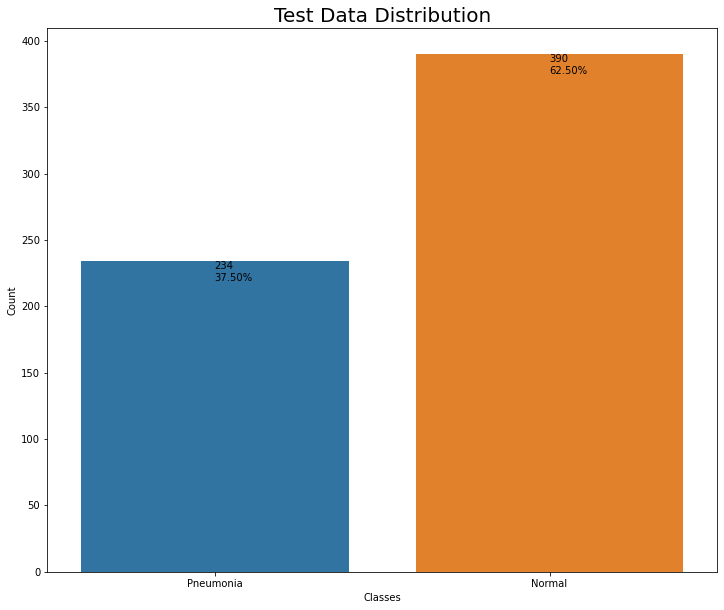

In [9]:
#test data distribution
test_labels = test_generator.classes
plot_class_counts(test_labels, 'Test Data Distribution')

This distribution shows that about 38% is classified as having pneumonia while the other 62% is normal.

#### Validation Data Visual

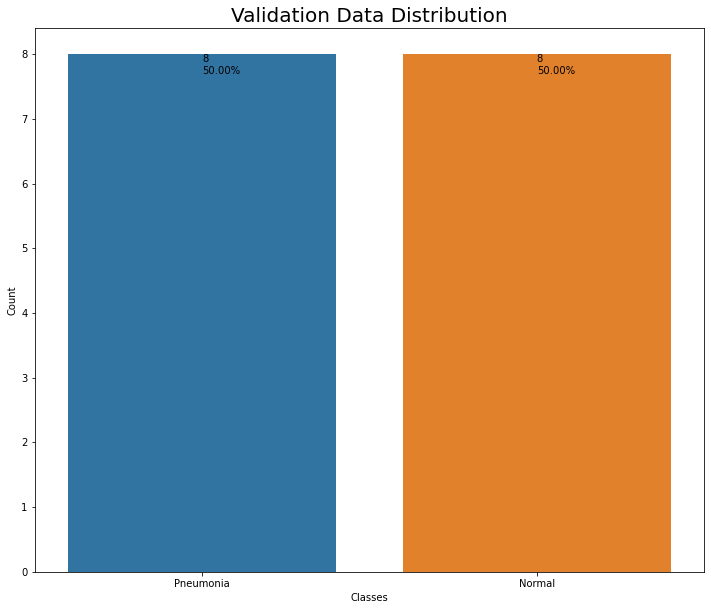

In [10]:
#validation data distribution
vals_labels = val_generator.classes
plot_class_counts(vals_labels, 'Validation Data Distribution')

This last distribution is split 50/50 down the middle with an equal representation for sick and normal patients.

#### Compare Size Distribution

Create a visualization to compare the differences in dimensions between the two classes

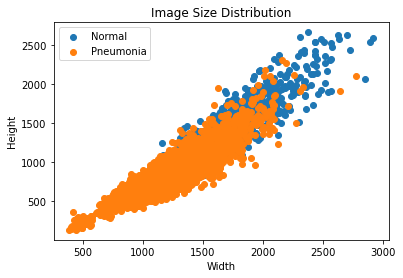

In [11]:
from PIL import Image
normal_image_sizes = []
pneumonia_image_sizes = []
for image_path in train_generator.filepaths:
    img = Image.open(image_path)
    width, height = img.size
    if "NORMAL" in image_path:
        normal_image_sizes.append((width, height))
    else:
        pneumonia_image_sizes.append((width, height))
normal_image_sizes = np.array(normal_image_sizes)
pneumonia_image_sizes = np.array(pneumonia_image_sizes)
plt.scatter(normal_image_sizes[:, 0], normal_image_sizes[:, 1], label='Normal')
plt.scatter(pneumonia_image_sizes[:, 0], pneumonia_image_sizes[:, 1], label='Pneumonia')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

At first glance, one can note that it seems that the images of the x-rays that represent patients with pneumonia seem to have a smaller hight and width than that of the images belonging to the normal x-rays. However, there does seem to be a bit of overlapping between the two.

### Data Preparation

Obtain images and labels from the train, test and validation generators where the images and labels are returned as arrays. The train_images array contains the image data, and the train_labels array contains the corresponding labels.

In [12]:
# obtain images and labels from the test generator
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Explore and display information about the shape and size of the image and label datasets. By printing these values, we can get an overview of the number of samples and the dimensions of the image and label arrays in our dataset.

In [13]:
# Explore the shape of the images and labels
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

train_labels =np.array(train_labels)
test_labels =np.array(test_labels)
val_labels = np.array(val_labels)


print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216,)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624,)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16,)


In [14]:
# Reshaping the images
# number of images per data, 128X128X3
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 49152)
(624, 49152)
(16, 49152)


## Modeling

### Model 1: Baseline Model/ Densely Connected Neural Network

Build a baseline densely connected network with two hidden layers and an output layer. The first two layers have ReLU activation, which introduces non-linearity to the model. The final layer uses a sigmoid activation function, which produces a probability output between 0 and 1 for binary classification.

In [15]:
#initialize a sequential model
model_1 = models.Sequential()

#add two layers with relu activation
model_1.add(layers.Dense(64, activation='relu', input_shape=(49152,))) 
model_1.add(layers.Dense(32, activation='relu'))

#add one layer with sigmoid activation
model_1.add(layers.Dense(1, activation='sigmoid'))

In [16]:
#create a model
model_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
#get a summary of the model created
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3145792   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,147,905
Trainable params: 3,147,905
Non-trainable params: 0
_________________________________________________________________


In [18]:
#train the model
results_1 = model_1.fit(train_img,
                    train_labels,
                    epochs=10,
                    batch_size=100,

                    validation_data=(val_img, val_labels))

Epoch 1/10
53/53 [==============================] - 2s 29ms/step - loss: 0.6148 - accuracy: 0.7220 - val_loss: 1.2147 - val_accuracy: 0.5000
Epoch 2/10
53/53 [==============================] - 1s 20ms/step - loss: 0.4764 - accuracy: 0.7789 - val_loss: 0.7493 - val_accuracy: 0.5000
Epoch 3/10
53/53 [==============================] - 1s 19ms/step - loss: 0.3782 - accuracy: 0.8430 - val_loss: 0.4796 - val_accuracy: 0.7500
Epoch 4/10
53/53 [==============================] - 1s 19ms/step - loss: 0.3885 - accuracy: 0.8514 - val_loss: 0.4513 - val_accuracy: 0.8125
Epoch 5/10
53/53 [==============================] - 1s 19ms/step - loss: 0.3047 - accuracy: 0.8898 - val_loss: 0.8722 - val_accuracy: 0.6250
Epoch 6/10
53/53 [==============================] - 1s 19ms/step - loss: 0.2771 - accuracy: 0.8863 - val_loss: 1.2450 - val_accuracy: 0.6250
Epoch 7/10
53/53 [==============================] - 1s 19ms/step - loss: 0.2915 - accuracy: 0.8900 - val_loss: 1.0275 - val_accuracy: 0.6250
Epoch 8/10
53

Create a visual to see the the loss and validation loss as well as the accuracy and validation accuracy of the model. This will help to show if there are issues such as overfitting within the model.

In [19]:
#create a function to plot the loss and Accuracy curves
def visualize_training_results_dense(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

#### Model 1 Visualization

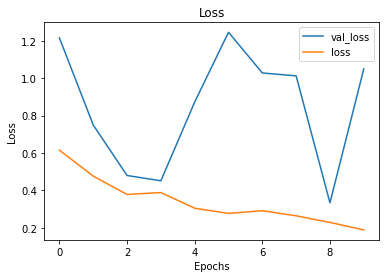

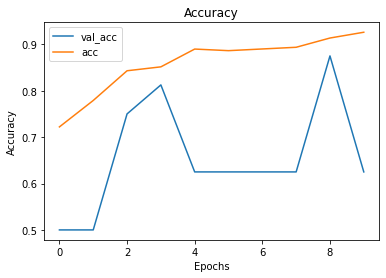

In [20]:
visualize_training_results_dense(results_1)

In [21]:
#create a function that return loss and accuracy of a model
def model_metrics(model, images, labels):
    return model.evaluate(images, labels)

In [22]:
results_train = model_metrics(model_1, train_img, train_labels)
results_train

163/163 [==============================] - 1s 7ms/step - loss: 0.2829 - accuracy: 0.8788


[0.2828642725944519, 0.8788343667984009]

In [23]:
results_val = model_metrics(model_1, val_img, val_labels)
results_val

1/1 [==============================] - 0s 0s/step - loss: 1.0492 - accuracy: 0.6250


[1.04920494556427, 0.625]

The first model had a validation accuracy of 62 percent and a training accuracy of 87 percent. One can infer that this densely connected neural network has a poor performance due to the poor validation score; validation loss of 1.04. The training loss and validation loss have a large gap between thhem of approximately 0.76. Another sign of overfitting is that the curves diverge in different directions.

### Model 2: Convolutional Neural Network

The second model being built is a convolutional neural network (cnn) model. The model will have two convolutional layers to extract feautures from the images, followed by max pooling layers, and a final fully connected layer to perform the classification.

In [24]:
model_2 = models.Sequential()

#add 2 convolutional layers with pooling
model_2.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(128 , 128,  3)))
#downsampling the previous convolutional network
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(32, (3,3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

#flattening to convert the 2d array in a 1d to feed in the next layer
model_2.add(layers.Flatten())
model_2.add(layers.Dense(1, activation='sigmoid'))

In [25]:
#compile the second model
model_2.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [26]:
#get a quick summary of the model just created
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 28801     
Total params: 49,057
Trainable params: 49,057
Non-trainable params: 0
__________________________________________________

In [27]:
#Function to plot the loss function
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [28]:
results_2 = model_2.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_data=(val_images, val_labels))

Epoch 1/10
53/53 [==============================] - 44s 833ms/step - loss: 0.5358 - acc: 0.7529 - val_loss: 0.6543 - val_acc: 0.5625
Epoch 2/10
53/53 [==============================] - 42s 797ms/step - loss: 0.4618 - acc: 0.8106 - val_loss: 0.6229 - val_acc: 0.6250
Epoch 3/10
53/53 [==============================] - 42s 800ms/step - loss: 0.3976 - acc: 0.8267 - val_loss: 0.7216 - val_acc: 0.6250
Epoch 4/10
53/53 [==============================] - 43s 805ms/step - loss: 0.2900 - acc: 0.8857 - val_loss: 1.1035 - val_acc: 0.6250
Epoch 5/10
53/53 [==============================] - 600s 11s/step - loss: 0.2931 - acc: 0.8848 - val_loss: 0.4026 - val_acc: 0.7500
Epoch 6/10
53/53 [==============================] - 42s 784ms/step - loss: 0.2239 - acc: 0.9130 - val_loss: 2.9486 - val_acc: 0.5000
Epoch 7/10
53/53 [==============================] - 42s 790ms/step - loss: 0.2171 - acc: 0.9172 - val_loss: 0.6714 - val_acc: 0.6250
Epoch 8/10
53/53 [==============================] - 42s 792ms/step - l

Create a visual to see the the loss and validation loss as well as the accuracy and validation accuracy of the model. This will help to show if there are issues such as overfitting within the model.

#### Model 2 Visualization

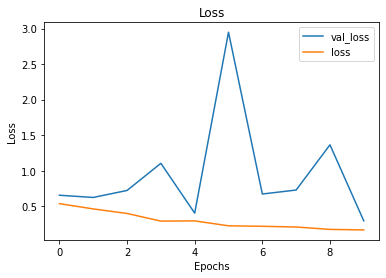

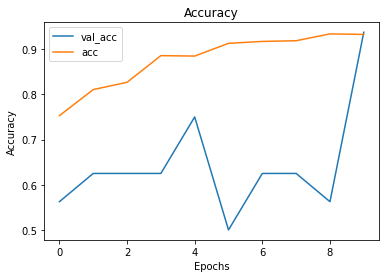

In [29]:
visualize_training_results(results_2)

In [30]:
#Model 2 training results
results_train = model_metrics(model_2, train_images, train_labels)
results_train

163/163 [==============================] - 10s 63ms/step - loss: 0.1648 - acc: 0.9371 0s - loss: 0.1663 -


[0.16478024423122406, 0.9371165633201599]

In [31]:
#Model 2 validation results
results_val = model_metrics(model_2, val_images, val_labels)
results_val

1/1 [==============================] - 0s 4ms/step - loss: 0.2934 - acc: 0.9375


[0.2933884263038635, 0.9375]

The second model preformed much better than the first model. With a training loss of 0.16 and training accuracy of 0.93. As well as a validation loss of 0.29 and validation accuracy of 0.93. This model seems to have also delt with the overfitting. This can be seen through there being a small margin between the training loss and validation loss (approx. 0.13) and the curves are no longer diverging at the ends of the graph.

### Model 3: CNN Model Tuning with More Layers

Seeing that the convolutional neural network had a very good performance, the third model will expand on it and attempt to refine it by adding more layers to it. This will be done by adding more convolutional layers as well as more dense layers.

In [32]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))


model_3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(512, activation='relu'))
model_3.add(layers.Dense(256, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [33]:
# compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
results_3 = model_3.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 [==============================] - 44s 271ms/step - loss: 0.4384 - accuracy: 0.8085 - val_loss: 2.0675 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 45s 273ms/step - loss: 0.1682 - accuracy: 0.9362 - val_loss: 0.5367 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - 44s 270ms/step - loss: 0.1085 - accuracy: 0.9594 - val_loss: 0.9610 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 45s 275ms/step - loss: 0.0796 - accuracy: 0.9718 - val_loss: 0.1654 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 45s 273ms/step - loss: 0.0589 - accuracy: 0.9778 - val_loss: 0.5532 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 45s 274ms/step - loss: 0.0432 - accuracy: 0.9847 - val_loss: 0.1186 - val_accuracy: 0.9375
Epoch 7/10
163/163 [==============================] - 45s 278ms/step - loss: 0.0405 - accuracy: 0.9854 - val_loss: 0.4735 - val_ac

#### Model 3 Visualization

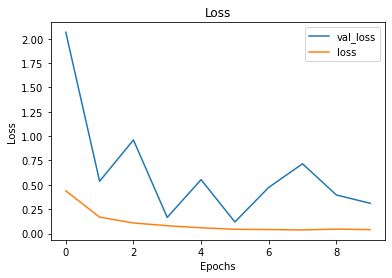

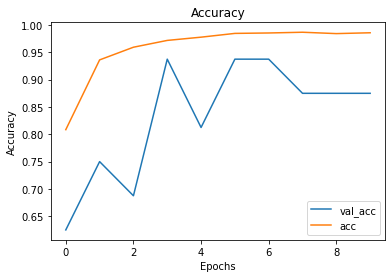

In [35]:
visualize_training_results_dense(results_3)

In [36]:
#Model 3 training results
results_train = model_metrics(model_3, train_images, train_labels)
results_train

163/163 [==============================] - 11s 66ms/step - loss: 0.0156 - accuracy: 0.9942


[0.015644388273358345, 0.9942484498023987]

In [37]:
#Model 3 validation results
results_val = model_metrics(model_3, val_images, val_labels)
results_val

1/1 [==============================] - 0s 4ms/step - loss: 0.3104 - accuracy: 0.8750


[0.3103933036327362, 0.875]

This model had a very high training accuracy with a score of 0.99 and a training loss of barely 0.01. It also had a validation accuracy of 0.87 and validation loss of 0.31. This is also a well performing model as it seems that both curves trend in the same direction. The gap between the training loss and validaation loss is that of approx. 0.3.

### Model 4: CNN Tuning with Layers, Dropout, & Regularization

In this fourth model, the original CNN model will be tuned and refined even more in an attempt to further improve it. This time around adding the extra layers plus dropout layers with a rate of 0.25, L1 and L2 regularization with a factor of 0.01. All this in an attempt to further improve the training and validation scores as well as reducing the overfitting.

In [38]:
model_4 = models.Sequential()

model_4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Dropout(0.25))  


model_4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))) 
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Dropout(0.25))


model_4.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Dropout(0.25))


model_4.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Dropout(0.25))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.Dense(256, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [39]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
results_4 = model_4.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 [==============================] - 34s 211ms/step - loss: 14.1038 - accuracy: 0.7429 - val_loss: 1.2518 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 34s 207ms/step - loss: 1.0162 - accuracy: 0.7429 - val_loss: 1.2341 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 34s 210ms/step - loss: 1.0113 - accuracy: 0.7429 - val_loss: 1.2906 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 35s 214ms/step - loss: 1.0070 - accuracy: 0.7429 - val_loss: 1.2647 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 35s 217ms/step - loss: 1.0018 - accuracy: 0.7429 - val_loss: 1.2287 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 36s 218ms/step - loss: 0.9973 - accuracy: 0.7429 - val_loss: 1.2996 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 35s 212ms/step - loss: 0.9979 - accuracy: 0.7429 - val_loss: 1.2717 - val_a

#### Model 4 Visualization

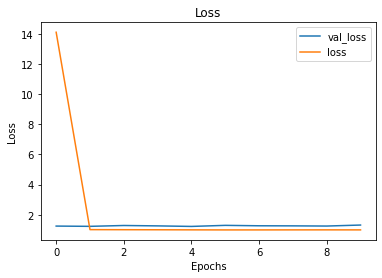

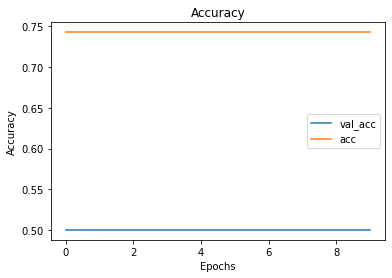

In [41]:
visualize_training_results_dense(results_4)

In [42]:
#Model 4 training results
results_train = model_metrics(model_4, train_images, train_labels)
results_train

163/163 [==============================] - 8s 48ms/step - loss: 1.0023 - accuracy: 0.7429


[1.002334713935852, 0.7429064512252808]

In [43]:
#Model 4 validation results
results_val = model_metrics(model_4, val_images, val_labels)
results_val

1/1 [==============================] - 0s 0s/step - loss: 1.3202 - accuracy: 0.5000


[1.3201837539672852, 0.5]

The results for the fourth model are poor. Reporting back a training accuracy of 0.74 and validation accuracy of 0.5. And a training loss of 1.0 and validation loss of 1.32. The results are most likely attributed to the extra layers and tuning causing the model to be too complex and overfitted instead of fixing the overfitting. Most likey attributed to too much tuning and not enough data.

### Evaluation

The best performing model out of the four models created was Model 2: Convolutional Neural Netwroks Model and Model 3: CNN with More Layers. For that reason, these models will be used for the testing dataset.

In [44]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_metrics(model_2, test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 1s 74ms/step - loss: 0.4126 - acc: 0.8109
Test Loss: 0.4126065969467163
Test Accuracy: 0.8108974099159241


The second model reported a 0.41 test loss and a test accuracy of 0.81

In [45]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_metrics(model_3, test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 1s 73ms/step - loss: 1.4216 - accuracy: 0.8061
Test Loss: 1.4215916395187378
Test Accuracy: 0.8060897588729858


The third model showed a test loss of 1.4 and a test accuracy of 0.8

After seeing how the two models performed on the testing data, it is evident that model 2 is the better performing model with the higher accuracy and lower loss.

###  Create Predictions

In [50]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_2.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)


Create a visual showing the predicted images for the NORMAL and PNEUMONIA patients

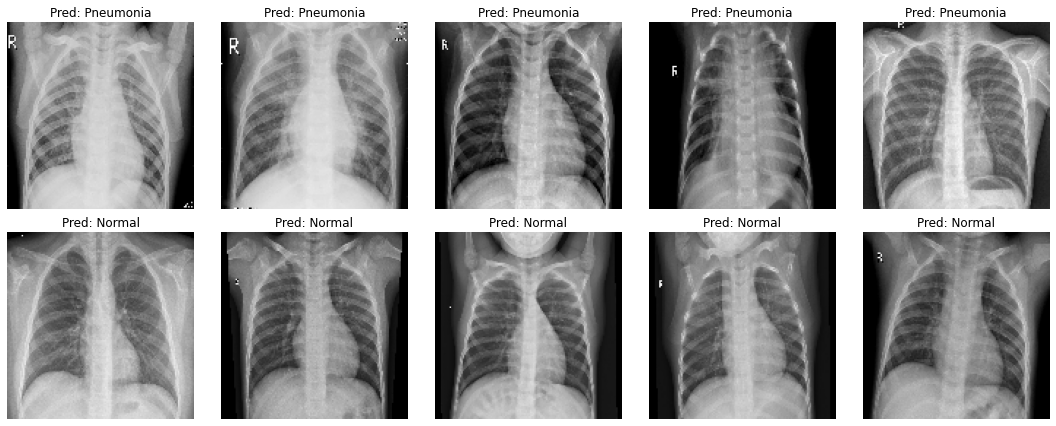

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Convert predictions to class labels (0 or 1)
predicted_labels = np.round(prediction)

# Create an array of indices
indices = np.arange(len(predicted_labels))

# Shuffle the indices
np.random.shuffle(indices)

# Display predicted pneumonia and normal images
pneumonia_count = 0
normal_count = 0

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in indices:
    if pneumonia_count >= 5 and normal_count >= 5:
        break

    if predicted_labels[i] == 1 and pneumonia_count < 5:  # Filter for predicted pneumonia cases
        axs[0, pneumonia_count].imshow(test_images[i])
        axs[0, pneumonia_count].axis('off')
        axs[0, pneumonia_count].set_title(f"Pred: Pneumonia")
        pneumonia_count += 1

    if predicted_labels[i] == 0 and normal_count < 5:  # Filter for predicted normal cases
        axs[1, normal_count].imshow(test_images[i])
        axs[1, normal_count].axis('off')
        axs[1, normal_count].set_title(f"Pred: Normal")
        normal_count += 1

plt.tight_layout()
plt.show()

Get a classification report to get further feedback on the performance of the data

In [52]:
# Convert predictions to binary values
binary_predictions = np.round(prediction)

# Ensure test_labels are binary values
binary_labels = np.array(test_labels)

# Print the classification report
print(classification_report(binary_labels, binary_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.88      0.58      0.70       234
   PNEUMONIA       0.79      0.95      0.86       390

    accuracy                           0.81       624
   macro avg       0.83      0.76      0.78       624
weighted avg       0.82      0.81      0.80       624



The recall score of 0.95 for the "PNEUMONIA" class means that the model correctly identified 95% of the actual pneumonia cases in the dataset. This indicates a high sensitivity of the model in detecting pneumonia, as it has a low likelihood of missing positive cases.

## Results

After taking a look at various models built, the following was found. The basline densely connected neural network model (model_1) as lacking due to overfitting and having poor loss and accuracy scores. As well as the CNN model with included layers, dropouts, and regulazation (model_4). This model lacking in being overly tuned, which led to overfitting and also poor loss and accuracy results. The two models that stood out were the convolutional neural network model (model_2) and the CNN model with added layers (model_3). Boths these models having better loss and accuracy resluts than their predecessors, and also seemingly being less likely to be overfitting. Upon this finding both of these models were ran on the testing data for evaluation, and model 2 returned the better results for test_loss (0.41 vs 1.41) and better results in terms of test_accuracy (0.81 vs 0.80). After establishing our predictions using model_2, a classification report was called to better see the performance of the predictioins generated from the chosen model. With patients with pneumonia having an f1-score of 0.86, recall of 0.95, and precision of 0.79.

## Conclusion

This analysis consisted of attempting to successfullfy build the most efficient model for image classification. Ultimately the best performing model recommended for the Guangzhou Women and Children’s Medical Center to use in their attempt to helping detect pneumonia in patient x-rays would be the convolutional neural network model as it yielded the best results. This model coming with a recall score for sick patients of 0.95. Meaning that there is a 95% chance that this model will correctly be able to identify a person that is testing positive for pneumonia (true positive). Although the recall score for normal patients didnt come back as high as one would desire (true negatives), this is something that can often occur when making these models. However, it is more important to correctly identify a sick person correcly and try to minimize as many false positives as possible in this situation. This is because it is more harmful for a sick person to walk out not knowing that they have pneumonia and not be given treatment, than for a normal person who is fine to mistakenly be told that they have tested positive and still be given treatment even though they are fine. To further improve this model, more samples of different x-rays could be collected or one could further try different methods to tune this model. To further test this model, the Guangzhou Women and Children’s Medical Center could share this model with other hospitals and clinics to see how well the model performs for them.

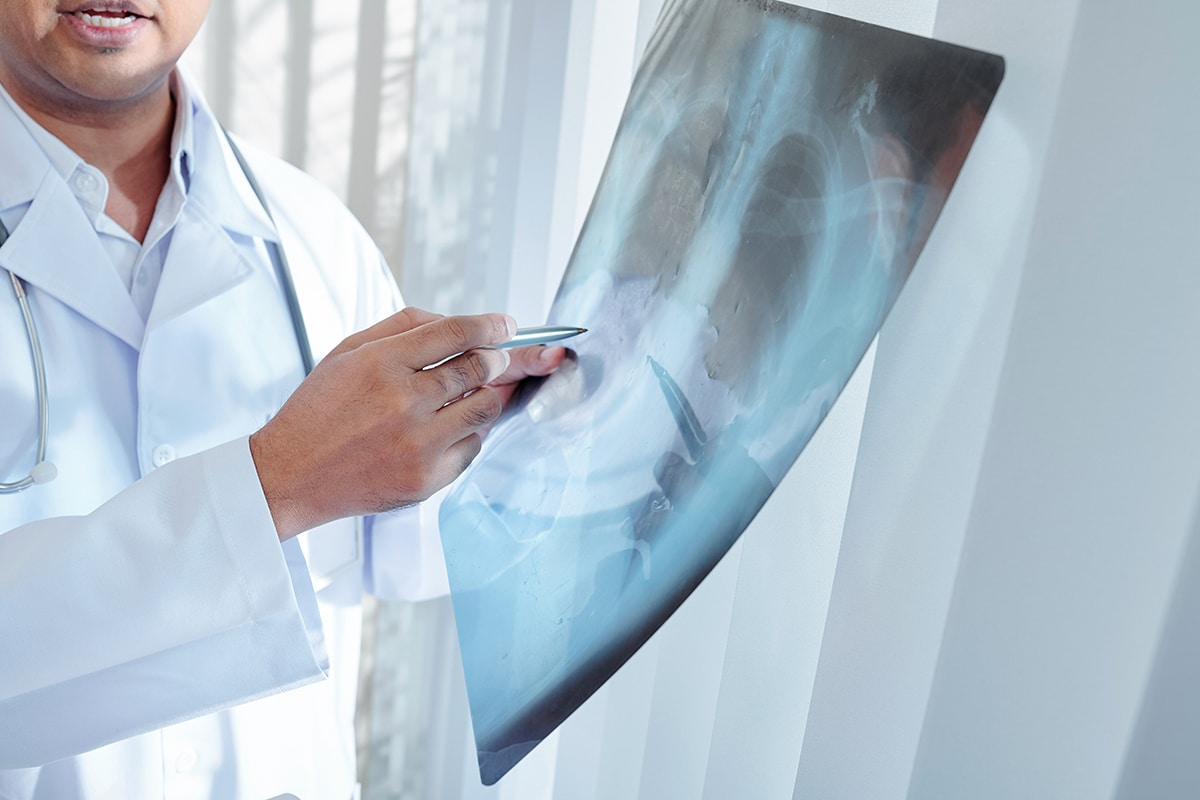